In [19]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.ops.indexing import Vindex
import jax.numpy as jnp

assert numpyro.__version__.startswith("0.9.2")

import numpy as np
import scipy.stats as ss
import random

## Generate Test Data

In [2]:
N = 1000 # Rough nucleotide sequence length of gene
heterozygosity = 0.045
alphabet = {"A":0, "C":1, "G":2, "T":3}
genotypes = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":1, "CC":4, "CG":5, "CT":6,
    "GA":2, "GC":4, "GG":7, "GT":8, 
    "TA":3, "TC":6, "TG":8, "TT":9,
}

In [3]:
snp_positions = np.sort(random.sample(range(N),round(N*heterozygosity))) # [loc for i in range(round(N*heterozygosity))]
sequence = "".join(np.random.choice(list(alphabet.keys()), N))

print(f"Uniformly selected SNP loci:\n{snp_positions}")
print(f"\nReference sequence of randomly generated gene sequence:\n{sequence}")

Uniformly selected SNP loci:
[ 16  46  58  94 102 106 135 141 167 188 230 289 313 318 346 355 381 423
 434 435 457 482 487 504 529 546 564 572 586 608 658 660 666 708 720 756
 762 765 769 773 846 876 917 968 986]

Reference sequence of randomly generated gene sequence:
GTTTCCGAACCGCCTAGCGACGCCACGCCTTGATGTATGCACGTTAACCCCTTGAGGATTGCGAATCCTATATCTGCTAATCTCAATGGCGGGTGTCACTACTCAACTTTGCCCCTCAGGATCCTTGGTGCAGCATGACGCTTTTACGCCTCATCTTGGGAAAACGGCGTTGTGGAGGTGTGTCAATACATGTTACAGTAGTCTCCTCTTTTCGCACTGGTTTTCAGCTTCTTTAACGGGTGACTACCAAGCGGAACCACATGAGACCGGGATAGCTCAGGATTACGATATTAGGTAAGAGCGACTCCCGATTATAGTACTCGAGTTATAGCTTATCGATGATCCGGAAATCGGCGCCGACCGGGGAAGCATACACTCGCTAGCCGTTCAAACTCGGGCTGTGCAATCATACACACGGCCTGCCGAACGGTATCCTTCGTATGCAATACCTAGTGGGACCAGCCCATCTGTTATCCGAATCCCCTATCGATCCCGGCGAGAACCATCGACTTGATGTACATGTGTCGCAGAACGCGAAGCCGCGAGCCGTTGATGTCAATGGCCGGTAAGCCATGTGAGCCTACAGAGGCATATGCCATATGCTGAGCTTGCGGAACTGGTATGGATGATCTCACCCACGAGCTCCTGACTAAGTCCCTACAAAAAGCTCACCGCCGACACCGCCTATCATCACCGATCCGCCCAGCGGCTGCCCATAGTTTCTAGCTAT

In [4]:
class EmbryoSequenceSimulator:
    def __init__(self, reference, snp_profile, n_embryos):
        self.reference = reference
        self.snp_profile = snp_profile
        self.n_embryos = n_embryos
        
        # Number of cells that can be harvested from embryo
        self.n_cells = 2
        self.alphabet = {"A":0, "C":1, "G":2, "T":3}

    def embryo_sequence_simulation(self):
        sequences = self.parental_seeding()

        # TODO: check that m0 can only cross over with p0 (could it also crossver with p1?)
        m0,p0 = self.homologous_recombination(sequences["m0"],sequences["p0"])
        m1,p1 = self.homologous_recombination(sequences["m1"],sequences["p1"])

        # Choose pairs of parental chromatids that get inherited by embryo
        m_chromatid = m0 if random.random() <= 0.5 else m1
        p_chromatid = p0 if random.random() <= 0.5 else p1

        return self.n_cells, m_chromatid, p_chromatid

    def parental_seeding(self):
        sequences = {}
        for parent in ["m0", "m1", "p0", "p1"]: # m = maternal; p = paternal
            sequence = [char for char in self.reference]
            
            for locus,char in self.snp_profile.items():
                sequence[locus] = char
            sequences[parent] = "".join(sequence)
        return sequences

    def homologous_recombination(self, maternal, paternal):
        chiasma_point = random.choice(range(len(self.reference)))

        # Maybe not necessary, but intent is that either top or bottom half can cross over 
        if random.random() <= 0.5:
            updated_maternal = maternal[:chiasma_point]+paternal[chiasma_point:]
            updated_paternal = paternal[:chiasma_point]+maternal[chiasma_point:]
        else:
            updated_maternal = paternal[:chiasma_point]+maternal[chiasma_point:]
            updated_paternal = maternal[:chiasma_point]+paternal[chiasma_point:]

        return updated_maternal, updated_paternal        


In [5]:
profile = []
n_embryos=2
for i in range(n_embryos):
    snp_profile = {locus:random.choice(list(alphabet.keys())) for locus in snp_positions} # key: position; value: random nucleotide
    embryo = EmbryoSequenceSimulator(sequence,snp_profile,1)
    n_cells, m_chromatid, p_chromatid = embryo.embryo_sequence_simulation()
    # print(n_cells)
    # print(m_chromatid)
    # print(p_chromatid)
    loci = []
    for locus in snp_positions:
        genotype = "".join([m_chromatid[locus],p_chromatid[locus]])
        loci.append(genotypes[genotype])
    for j in range(n_cells):
        profile.append(loci)

X = np.array(profile)
print(X.shape)
print(X)

(4, 45)
[[9 9 7 9 7 7 4 4 9 0 4 9 4 9 9 4 7 4 0 0 7 9 4 4 9 7 4 9 4 0 4 4 7 0 0 0
  9 7 7 9 9 9 7 9 9]
 [9 9 7 9 7 7 4 4 9 0 4 9 4 9 9 4 7 4 0 0 7 9 4 4 9 7 4 9 4 0 4 4 7 0 0 0
  9 7 7 9 9 9 7 9 9]
 [4 9 7 9 0 9 7 0 9 0 9 0 4 7 9 4 7 4 0 7 7 7 4 9 0 0 9 4 0 9 0 4 7 9 4 0
  9 7 9 0 4 7 4 4 4]
 [4 9 7 9 0 9 7 0 9 0 9 0 4 7 9 4 7 4 0 7 7 7 4 9 0 0 9 4 0 9 0 4 7 9 4 0
  9 7 9 0 4 7 4 4 4]]


## Implement Model

In [6]:
S = 10 # The number of possible states
states = [['A','A'], ['A','C'], ['A','G'], ['A','T'], ['C','C'], ['C','G'], ['C','T'], ['G','G'], ['G','T'], ['T','T']]

K = 2 # Number of embryos
kappa = np.ones(K) # The prior on pi

gamma = []

# Set the gamma prior
# Single allele states have most of the weight in the true state
# Two allele states have the weight distributed between the true state and the single allele versions
for i in range(len(states)):
    weights = 0.1*np.ones(S)
    
    cur_state = states[i]
    
    if cur_state[0] == cur_state[1]:
        weights[i] = 10
    else:
        for j in range(len(states)):
            is_first_allele = (states[j][0] == cur_state[0] and states[j][1] == cur_state[0])
            is_second_allele =  (states[j][0] == cur_state[1] and states[j][1] == cur_state[1])
            
            if  is_first_allele or is_second_allele:
                weights[j] = 10
        
        weights[i] = 10
        
    gamma.append(weights)
                
gamma = jnp.array(gamma)

In [7]:
X.shape

(4, 45)

In [154]:
from numpyro.contrib.funsor import config_enumerate

In [192]:
def sc_genotyper(S, kappa, gamma, K, X):
    # Sample pi from prior
    pi = numpyro.sample('pi', dist.Dirichlet(kappa))
        
    # Sample epsilon from prior
    with numpyro.plate('S', S) as s:
        epsilon = numpyro.sample('epsilon', dist.Dirichlet(gamma[s]))
            
    num_cells = X.shape[0]
    num_loci = X.shape[1]
    
    # Sample G from prior
    with numpyro.plate('K', K):
        with numpyro.plate('M', num_loci):
            G = numpyro.sample('G', dist.Categorical(1/S*jnp.ones(S)))
        
    with numpyro.plate('N', num_cells, dim=-2):
        Z_n = numpyro.sample('Z_n', dist.Categorical(pi))
        
        with numpyro.plate('M', num_loci, dim=-1) as m:
            v = Vindex(G)[Z_n, m]
            e = Vindex(epsilon)[v]
            
            numpyro.sample('X_{nm}', dist.Categorical(e), obs=X)

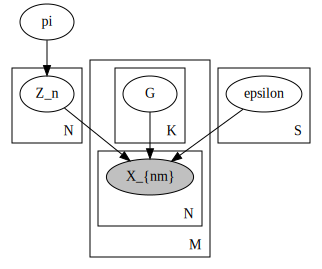

In [196]:
numpyro.render_model(sc_genotyper, model_args=(S, kappa, gamma, K, X))

In [193]:
from jax import random
from numpyro.infer import MCMC, NUTS
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS

nuts_kernel = NUTS(sc_genotyper)
kernel = DiscreteHMCGibbs(nuts_kernel)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=10000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, S, kappa, gamma, K, X)

sample: 100%|██████████| 12000/12000 [00:58<00:00, 204.86it/s, 63 steps of size 5.85e-02. acc. prob=0.91]


In [194]:
mcmc.print_summary()  


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      G[0,0]      6.60      2.43      7.00      2.00      9.00    406.10      1.00
      G[0,1]      7.00      2.20      8.00      2.00      8.00    333.01      1.00
      G[1,0]      6.55      2.55      8.00      2.00      9.00    397.84      1.00
      G[1,1]      6.91      2.28      8.00      2.00      8.00    332.24      1.01
      G[2,0]      4.53      2.87      5.00      1.00      9.00   9174.87      1.00
      G[2,1]      4.50      2.89      4.00      0.00      9.00  10037.97      1.00
      G[3,0]      4.47      2.86      4.00      0.00      8.00   9752.98      1.00
      G[3,1]      4.55      2.89      5.00      1.00      9.00   9904.23      1.00
      G[4,0]      4.57      2.88      5.00      1.00      9.00  10132.11      1.00
      G[4,1]      4.49      2.86      4.00      0.00      8.00   9624.79      1.00
      G[5,0]      4.49      2.89      4.00      0.00      9.00  10073.04      1.00
   

In [195]:
mcmc.get_samples()['Z_n']

DeviceArray([[[1],
              [1],
              [0],
              [0]],

             [[1],
              [1],
              [0],
              [0]],

             [[1],
              [1],
              [0],
              [0]],

             ...,

             [[0],
              [0],
              [1],
              [1]],

             [[0],
              [0],
              [1],
              [1]],

             [[0],
              [0],
              [1],
              [1]]], dtype=int32)